In [1]:
import numpy as np
import pandas as pd
import torch
import sys
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.append('/home/benoit.sautydechalon/deformetrica')

from deformetrica.core.estimator_tools.samplers.srw_mhwg_sampler import SrwMhwgSampler
from deformetrica.core.estimators.gradient_ascent import GradientAscent
from deformetrica.core.estimators.mcmc_saem import McmcSaem
# Estimators
from deformetrica.core.estimators.scipy_optimize import ScipyOptimize
from deformetrica.core.model_tools.manifolds.exponential_factory import ExponentialFactory
from deformetrica.core.model_tools.manifolds.generic_spatiotemporal_reference_frame import GenericSpatiotemporalReferenceFrame
from deformetrica.core.models.longitudinal_metric_learning import LongitudinalMetricLearning
from deformetrica.core.models.model_functions import create_regular_grid_of_points
from deformetrica.in_out.array_readers_and_writers import read_2D_array
from deformetrica.in_out.dataset_functions import read_and_create_scalar_dataset, read_and_create_image_dataset
from deformetrica.support.probability_distributions.multi_scalar_normal_distribution import MultiScalarNormalDistribution
from deformetrica.support.utilities.general_settings import Settings
from deformetrica import estimate_longitudinal_metric_model
from deformetrica.in_out.array_readers_and_writers import *
from deformetrica.launch.estimate_longitudinal_metric_model import instantiate_longitudinal_metric_model
import deformetrica as dfca

[pyKeOps]: Warning, cuda was detected, but driver API could not be initialized. Switching to cpu only.


In [3]:
path = 'simulated_study/'
output_folder = 'output_metric_4/'

## 1. Loading the individual parameters and raw data

In [38]:
rer = np.load(path+output_folder+'LongitudinalMetricModel__EstimatedParameters__IndividualRandomEffectsSamples.npy', 
              allow_pickle=True)[()]
trajectories = np.load(path+output_folder+'LongitudinalMetricModel__EstimatedParameters__Trajectory.npy',
       allow_pickle=True)[()]
ids = pd.read_csv(path+output_folder+'LongitudinalMetricModel_subject_ids_unique.txt', header=None).values

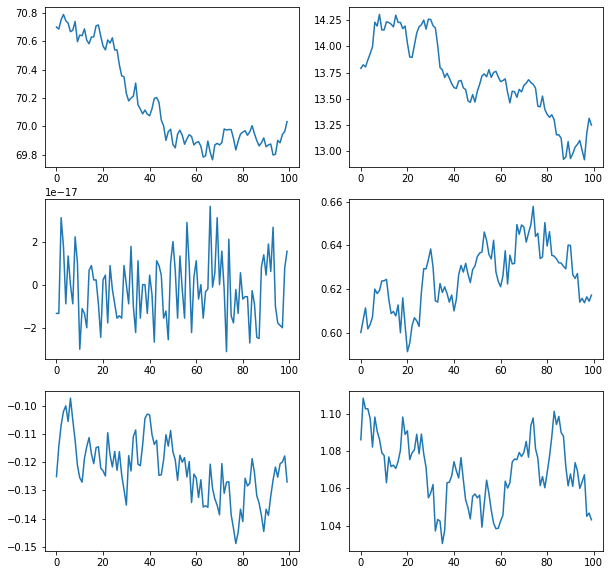

In [39]:
# Plot the non burn-in iterations
fig, axes = plt.subplots(3,2, figsize=(10,10))

axes[0][0].plot(rer['onset_age'].mean(axis=1))
axes[0][1].plot(rer['onset_age'].std(axis=1))
axes[1][0].plot(rer['log_acceleration'].mean(axis=1))
axes[1][1].plot(rer['log_acceleration'].std(axis=1))
axes[2][0].plot(rer['sources'].mean(axis=1))
axes[2][1].plot(rer['sources'].std(axis=1))

plt.show()

In [8]:
# Then in the required format for the deformetrica model

rer['onset_age'] = rer['onset_age'].mean(axis=0)
rer['log_acceleration'] = rer['log_acceleration'].mean(axis=0)
rer['sources'] = np.array([[source] for source in rer['sources'].mean(axis=0)])
averaged_rer = rer
averaged_rer

{'onset_age': array([ 62.59649948,  72.69495126,  68.13860528,  65.72744611,
         73.68372648,  45.09352123,  75.64105321,  63.56004699,
         66.3817125 ,  66.47202216,  73.32065739,  74.33868609,
         59.92360746,  65.43072892,  72.22933622,  83.0860822 ,
         68.02523715,  74.62303225,  73.70554718,  91.72619058,
         70.85352523,  58.12076807,  67.32010606,  74.71077121,
         71.02180202,  75.88978857,  73.46717662,  80.74650139,
         76.0347742 ,  76.20798113,  70.68556353,  62.0846136 ,
         68.28574934,  70.54173963,  83.58509649,  63.48011542,
         70.69872007,  69.7747623 ,  70.93190501,  66.6935943 ,
         56.24339429,  63.99445577,  74.05701774,  76.09095639,
         79.06440227,  76.44994879,  74.37686522,  65.90822588,
         69.02850462,  60.3933798 ,  73.5770306 ,  59.02768338,
         49.66130514,  63.58397756,  57.04343801,  61.44475125,
         71.19780958,  74.38749991,  69.29274564,  78.15996278,
         72.03295453,  78.7

In [9]:
# First we put them in a dataframe for visualization purpose

ip = pd.DataFrame(columns=['tau','xi','source'], index=[int(idx[0]) for idx in ids])
ip['tau'] = rer['onset_age'].mean(axis=0)
ip['xi'] = rer['log_acceleration'].mean(axis=0)
ip['source'] = rer['sources'].mean(axis=0)

ip

ValueError: Length of values (1) does not match length of index (100)

In [22]:
data = pd.DataFrame(index=[ids, times], columns=['adas_memory', 'hippocampus'])
data['adas_memory'] = adas_memory
data['hippocampus'] = hippocampus
data

adas_memory  hippocampus
4    74.868477     0.407333     0.377389
     75.075706     0.518444     0.375055
     75.282936     0.466667     0.364087
     75.490158     0.540667     0.382969
     76.111847     0.511111     0.429288
...                     ...          ...
1425 78.461342     0.540667     0.242699
     79.093491     0.607333     0.267690
1430 84.350166     0.577778     0.745385
     84.780472     0.659333     0.774981
     86.071396     0.770444     0.804698

[942 rows x 2 columns]

In [18]:
times = [time[0] for time in pd.read_csv(path+'/simulated_data_metric_4/X.csv', header=None).values]
logistic = [score[0] for score in pd.read_csv(path+'/simulated_data_metric_4/Y.csv', header=None).values]
sum_logistic = [score[1] for score in pd.read_csv(path+'/simulated_data_metric_4/Y.csv', header=None).values]
ids = [int(idx[0]) for idx in pd.read_csv(path+'/output_metric_4/LongitudinalMetricModel_subject_ids.txt', header=None).values]

In [19]:
data = pd.DataFrame(index=[ids, times], columns=['logistic', 'sum_logistic'])
data['logistic'] = logistic
data['sum_logistic'] = sum_logistic
data

logistic  sum_logistic
0   82.808470  0.589851      0.831207
    83.308470  0.554417      0.829718
    83.808470  0.605021      0.857535
    84.308470  0.565467      0.823185
    84.808470  0.601570      0.867376
...                 ...           ...
149 80.813193  0.812459      1.072932
    81.313193  0.797912      1.073722
    81.813193  0.812102      1.054805
    82.313193  0.821202      1.061200
    82.813193  0.798345      1.019635

[1800 rows x 2 columns]

In [7]:
individual_parameters = pd.read_csv(path+'/simulated_data_metric_4/true_individual_parameters.csv').set_index('Unnamed: 0')
individual_parameters.index.name = 'ID'
individual_parameters

,xi,tau,source
ID,,,
0,0.000778,75.434876,-0.303909
1,-0.130923,67.489520,1.450554
2,-0.269149,79.975922,0.495407
3,0.571161,80.746610,0.314348
4,0.582679,80.642316,-0.923419
...,...,...,...
145,-0.619707,68.274343,0.164381
146,-0.202183,56.529737,1.163004
147,-0.769635,47.837213,-1.282483


In [6]:
estimated_parameters = pd.read_csv(path+'/simulated_data_metric_4/estimated_parameters.csv').set_index('Unnamed: 0')
estimated_parameters.index.name = 'ID'
estimated_parameters

,onset_age,log_acceleration,sources
ID,,,
0,78.383095,-0.049039,[-0.1056801]
1,72.041000,0.000000,[-0.06758834]
2,80.959056,0.031624,[0.32296029]
3,77.120905,-0.042159,[0.1663939]
4,74.475408,-0.022955,[-0.11397514]
...,...,...,...
145,72.377283,-0.073734,[0.00921277]
146,68.914048,-0.038792,[0.50569738]
147,70.067853,-0.023468,[-0.2843275]


In [5]:
tau = [tau[0] for tau in pd.read_csv(path+'/preprocessing_test_2/2_gradient_descent_on_the_mode/LongitudinalMetricModel_onset_ages.txt', header=None).values]
xi = [xi[0] for xi in pd.read_csv(path+'/preprocessing_test_2/2_gradient_descent_on_the_mode/LongitudinalMetricModel_log_accelerations.txt', header=None).values]
sources = [np.float(sources) for sources in pd.read_csv(path+'/preprocessing_test_2/2_gradient_descent_on_the_mode/LongitudinalMetricModel_sources.txt', header=None).values]

individual_parameters_after_initialization = pd.DataFrame(columns=individual_parameters.columns, index=individual_parameters.index)
individual_parameters_after_initialization['tau'] = tau
individual_parameters_after_initialization['xi'] = xi
individual_parameters_after_initialization['source'] = sources

NameError: name 'individual_parameters' is not defined

In [14]:
tau = [tau[0] for tau in pd.read_csv(path+output_folder+'LongitudinalMetricModel_onset_ages.txt', header=None).values]
xi = [xi[0] for xi in pd.read_csv(path+output_folder+'LongitudinalMetricModel_log_accelerations.txt', header=None).values]
sources = [np.float(sources) for sources in pd.read_csv(path+output_folder+'LongitudinalMetricModel_sources.txt', header=None).values]

estimated_ip = pd.DataFrame(columns=individual_parameters.columns, index=individual_parameters.index)
estimated_ip['tau'] = tau
estimated_ip['xi'] = xi
estimated_ip['source'] = sources

In [17]:
abs(individual_parameters - estimated_ip).describe()

,xi,tau,source
count,100.000000,100.000000,100.000000
mean,0.346972,5.472662,6.147815
std,0.251198,5.668429,4.331544
min,0.002579,0.144356,0.419914
25%,0.131610,1.723376,2.827234
50%,0.310233,3.724393,5.025700
75%,0.526227,7.796171,8.599099
max,1.306482,35.669528,19.225902


In [32]:
path = 'mds_study'
times = [time[0] for time in pd.read_csv(path+'/output/LongitudinalMetricModel_absolute_times.txt', header=None).values]
mds1 = [score[0] for score in pd.read_csv(path+'/mds_data/MDS_values.csv', header=None).values]
mds2 = [score[1] for score in pd.read_csv(path+'/mds_data/MDS_values.csv', header=None).values]
ids = [int(idx[0]) for idx in pd.read_csv(path+'/output/LongitudinalMetricModel_subject_ids.txt', header=None).values]

In [33]:
data = pd.DataFrame(index=[ids, times], columns=['mds1', 'mds2'])
data['mds1'] = mds1
data['mds2'] = mds2
data

mds1      mds2
3001 59.910362  0.500000  0.133333
     59.982315  0.571429  0.133333
     60.215916  0.500000  0.133333
     60.449516  0.500000  0.200000
     60.683113  0.571429  0.200000
...                  ...       ...
3467 71.582550  0.500000  0.733333
     71.708649  0.714286  0.800000
     71.957832  0.357143  0.733333
     72.333115  0.357143  0.666667
     72.708397  0.357143  0.733333

[3000 rows x 2 columns]

In [35]:
reconstructed = pd.read_csv('mds_study/personalize_output/LongitudinalMetricModel_reconstructed_values.txt', sep=' ', header=None)
reconstructed.columns = ['mds1', 'mds2']
reconstructed.index = data.index

In [36]:
abs(reconstructed-data).describe()

,mds1,mds2
count,3000.000000,3000.000000
mean,0.163081,0.180404
std,0.134820,0.168752
min,0.000148,0.000094
25%,0.061791,0.060085
50%,0.131837,0.135601
75%,0.231493,0.250328
max,1.103094,2.036188


## 2. Evaluating the reconstruction error

In [4]:
estimated_parameters = pd.read_csv(path+'/simulated_data_metric_4/estimated_parameters.csv').set_index('Unnamed: 0')
estimated_parameters.index.name = 'ID'
estimated_parameters

,onset_age,log_acceleration,sources
ID,,,
0,78.383095,-0.049039,[-0.1056801]
1,72.041000,0.000000,[-0.06758834]
2,80.959056,0.031624,[0.32296029]
3,77.120905,-0.042159,[0.1663939]
4,74.475408,-0.022955,[-0.11397514]
...,...,...,...
145,72.377283,-0.073734,[0.00921277]
146,68.914048,-0.038792,[0.50569738]
147,70.067853,-0.023468,[-0.2843275]


In [8]:
path = 'simulated_study'
args = {'verbosity':'INFO', 'output':'personalize',
        'model':path+'/model_metric_4.xml', 'dataset':path+'/data_set.xml', 'parameters':path+'/optimization_parameters_saem.xml'}


"""
Read xml files, set general settings, and call the adapted function.
"""

xml_parameters = dfca.io.XmlParameters()
xml_parameters.read_all_xmls(args['model'],
                             args['dataset'],
                             args['parameters'])

logger = logging.getLogger(__name__)
logging.getLogger('matplotlib').setLevel(logging.ERROR)
logger.setLevel(logging.INFO)

In [9]:
dataset = read_and_create_scalar_dataset(xml_parameters)
model, individual_RER = instantiate_longitudinal_metric_model(xml_parameters, logger, dataset, observation_type='scalar')

In [10]:
onset_ages = torch.tensor(estimated_parameters['onset_age'])
log_accelerations = torch.tensor(estimated_parameters['log_acceleration'])
sources = torch.tensor([[float(source[1:-1])] for source in estimated_parameters['sources'].values])

In [11]:
v0, p0, metric_parameters, modulation_matrix = model._fixed_effects_to_torch_tensors(False)
#onset_ages, log_accelerations, sources = model._individual_RER_to_torch_tensors(individual_RER, False)
t0 = model.get_reference_time()

absolute_times = model._compute_absolute_times(dataset.times, log_accelerations, onset_ages)

absolute_times_to_write = []
for elt in absolute_times:
    for e in elt.cpu().data.numpy():
        absolute_times_to_write.append(e)

#np.savetxt(os.path.join(Settings().output_dir, "LongitudinalMetricModel_absolute_times.txt"), np.array(absolute_times_to_write))

model._update_spatiotemporal_reference_frame(absolute_times, p0, v0, metric_parameters,
                                            modulation_matrix)

162 good iterations out of 163
194 good iterations out of 199


In [12]:
predictions = []
subject_ids = []
times = []

targets = dataset.deformable_objects

number_of_subjects = dataset.number_of_subjects
residuals = []

for i in range(number_of_subjects):
    predictions_i = []
    for j, t in enumerate(absolute_times[i]):
        if sources is not None:
            prediction = model.spatiotemporal_reference_frame.get_position(t, sources=sources[i])
        else:
            prediction = model.spatiotemporal_reference_frame.get_position(t)
        predictions_i.append(prediction.cpu().data.numpy())
        predictions.append(prediction.cpu().data.numpy())
        subject_ids.append(dataset.subject_ids[i])
        times.append(dataset.times[i][j])

    targets_i = targets[i].cpu().data.numpy()


In [20]:
predicted = data.copy()
predicted['logistic'] = [prediction[0] for prediction in predictions]
predicted['sum_logistic'] = [prediction[1] for prediction in predictions]

In [21]:
diff = predicted - data
abs(diff).describe()

,logistic,sum_logistic
count,1776.000000,1776.000000
mean,0.026821,0.027692
std,0.038362,0.042542
min,0.000021,0.000005
25%,0.007290,0.007567
50%,0.016399,0.016235
75%,0.030633,0.029254
max,0.351595,0.361293


In [118]:
predicted.describe()

,logistic,sum_logistic
count,2000.000000,2000.000000
mean,0.508644,0.664127
std,0.173822,0.237593
min,0.260580,0.274014
25%,0.333731,0.468503
50%,0.509262,0.659124
75%,0.680889,0.888549
max,0.781632,1.061439


In [119]:
data.describe(percentiles=[.9])

,logistic,sum_logistic
count,2000.000000,2000.000000
mean,0.507838,0.661165
std,0.191308,0.237733
min,0.170156,0.258463
50%,0.508416,0.657581
90%,0.767370,0.994871
max,0.824501,1.040471


## Geodesic visualization

In [43]:
study = 'bivariate_study/'
output_folder = 'output/'

geodesic = pd.read_csv(study+output_folder+'LongitudinalMetricModel_reference_geodesic_trajectory_values.txt', sep=' ', header=None)
source_pos = pd.read_csv(study+output_folder+'LongitudinalMetricModel_source_0_pos.txt', sep=' ', header=None)
source_neg = pd.read_csv(study+output_folder+'LongitudinalMetricModel_source_0_neg.txt', sep=' ', header=None)

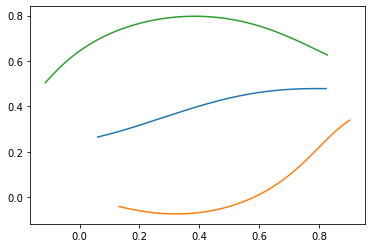

In [44]:
plt.plot(geodesic[0].values, geodesic[1].values)
plt.plot(source_pos[0].values, source_pos[1].values)
plt.plot(source_neg[0].values, source_neg[1].values)
plt.show()

## Comparing the parameters of successive runs

In [158]:
path_1 = 'simulated_study/multiple_runs_3/output_3_1'
path_2 = 'simulated_study/multiple_runs_3/output_3_2'

In [161]:
metric_parameters_1 = pd.read_csv(path_1+'/LongitudinalMetricModel_metric_parameters.txt', sep=' ', header=None)
metric_parameters_2 = pd.read_csv(path_2+'/LongitudinalMetricModel_metric_parameters.txt', sep=' ', header=None)

In [172]:
abs(metric_parameters_1 - metric_parameters_2).describe()/np.mean(np.mean(metric_parameters_1))

,0,1,2
count,473.043088,473.043088,473.043088
mean,0.024847,0.020683,0.072632
std,0.060620,0.060302,0.101194
min,0.001123,0.000015,0.001153
25%,0.007524,0.000920,0.020807
50%,0.007569,0.002055,0.047038
75%,0.008943,0.003592,0.095207
max,0.280928,0.249323,0.571259


In [166]:
metric_parameters_1.describe().loc['mean']

0    0.038198
1    0.002177
2    0.162566
Name: mean, dtype: float64

In [173]:
abs(metric_parameters_1 - metric_parameters_2).describe()

,0,1,2
count,32.000000,3.200000e+01,32.000000
mean,0.001681,1.399125e-03,0.004913
std,0.004101,4.079262e-03,0.006846
min,0.000076,1.000000e-06,0.000078
25%,0.000509,6.225000e-05,0.001408
50%,0.000512,1.390000e-04,0.003182
75%,0.000605,2.430000e-04,0.006441
max,0.019004,1.686600e-02,0.038644


In [171]:
np.mean(np.mean(metric_parameters_1))

0.06764711458333333